In [1]:
# import packages
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl

---

# *U.S. Treasury Bills:*
## Predicting 12-Month Rates, using 30 day windows of 3-Month and 6-Month Rates as input

---

## Data Wrangling

In [2]:
# set date range
start_date = "1982-01-04"
end_date = "2016-03-11"

In [3]:
# read in Fed Funds Rate, 3-Month, 6-Month, 12-Month Treasury Bill data from Quandl
three_month = Quandl.get("FRED/DGS3MO", trim_start=start_date, trim_end=end_date)
six_month = Quandl.get("FRED/DGS6MO", trim_start=start_date, trim_end=end_date)
twelve_month = Quandl.get("FRED/DGS1", trim_start=start_date, trim_end=end_date)

In [4]:
# reset indices 
three_month.reset_index(level=0, inplace=True)
six_month.reset_index(level=0, inplace=True)
twelve_month.reset_index(level=0, inplace=True)

In [5]:
# normalize data to heave mean = 0, std = 1
three_month['normal'] = (three_month['VALUE'] - three_month['VALUE'].mean(axis=0)) / three_month['VALUE'].std(axis=0, ddof=1)
six_month['normal'] = (six_month['VALUE'] - six_month['VALUE'].mean(axis=0)) / six_month['VALUE'].std(axis=0, ddof=1)
twelve_month['normal'] = (twelve_month['VALUE'] - twelve_month['VALUE'].mean(axis=0)) / twelve_month['VALUE'].std(axis=0, ddof=1)

In [6]:
# merge into single DataFrame
data = three_month.merge(six_month, on = 'DATE')
data = data.merge(twelve_month, on = 'DATE')

In [7]:
# rename columns
data.columns = ['date', '3_rate', '3_norm', '6_rate', '6_norm', '12_rate', '12_norm']

In [8]:
data.head(10)

,date,3_rate,3_norm,6_rate,6_norm,12_rate,12_norm
0,1982-01-04,11.87,2.437347,13.16,2.697099,13.56,2.716456
1,1982-01-05,12.20,2.541979,13.41,2.773836,13.83,2.797861
2,1982-01-06,12.16,2.529296,13.46,2.789183,13.91,2.821981
3,1982-01-07,12.17,2.532467,13.43,2.779975,13.93,2.828011
4,1982-01-08,11.98,2.472224,13.35,2.755419,13.75,2.773741
5,1982-01-11,12.49,2.633928,13.84,2.905824,14.31,2.942580
6,1982-01-12,12.52,2.643440,13.74,2.875129,14.18,2.903385
7,1982-01-13,12.70,2.700512,13.97,2.945727,14.51,3.002880
8,1982-01-14,13.17,2.849533,13.91,2.927310,14.41,2.972730
9,1982-01-15,12.74,2.713194,14.01,2.958005,14.53,3.008910


## Window 

In [9]:
index_count = 0

# create first entries of the sampling window
window_x = (data[['3_norm', '6_norm']].values[0:30]).reshape((1,60))
window_y = (data[['12_norm']].values[0:30]).reshape((1,30))

# iterate through the dataframe and append each successive sampling window
for i in xrange(30,8550,30):
    temp_x = (data[['3_norm', '6_norm']].values[i:i+30]).reshape((1,60))
    window_x = np.concatenate((window_x, temp_x))
    
    temp_y = (data[['12_norm']].values[i:i+30]).reshape((1,30))
    window_y = np.concatenate((window_y, temp_y)) 

    index_count += 1

In [10]:
# print shape of x window
window_x.shape

(285, 60)

In [11]:
# print shape of y window
window_y.shape

(285, 30)

## Train/Test Split

In [12]:
# concatenate x's and y's
window_x_y = np.concatenate((window_x, window_y), axis=1)

In [13]:
# print final window shape
window_x_y.shape

(285, 90)

In [14]:
# set random seed
np.random.seed(3232016)

# randomize the order of the window
np.random.shuffle(window_x_y)
window_x_y

array([[-1.30720101, -1.29015773, -1.31037167, ..., -1.26030584,
        -1.2482459 , -1.25729085],
       [ 0.54763431,  0.54539233,  0.54129299, ...,  0.53360894,
         0.51551904,  0.48536921],
       [ 1.19444868,  1.04878733,  1.16591275, ...,  1.05520096,
         1.04012605,  1.03409608],
       ..., 
       [ 0.53812233,  0.54232285,  0.53812233, ...,  0.54868385,
         0.54566887,  0.54868385],
       [ 0.31300557,  0.27220846,  0.31617623, ...,  0.28939533,
         0.32557512,  0.31653017],
       [ 0.22105647,  0.16784608,  0.18934988, ..., -0.18998694,
        -0.17189704, -0.15983711]])

In [15]:
# determine length for training set
train_length = (len(window_x_y)/3)*2
train_length

190

In [16]:
# allocate train data
train_data = window_x_y[:train_length,:]

# allocate test data
test_data = window_x_y[train_length:,:]

In [17]:
# print train data shape
train_data.shape

(190, 90)

In [18]:
# print test data shape
test_data.shape

(95, 90)

In [19]:
# allocate x and y of train data
x_train = train_data[:,:60]
y_train = train_data[:,60:]

# allocate x and y of test data
x_test = test_data[:,:60]
y_test = test_data[:,60:]

## Neural Network

In [20]:
from function_approximator import FunctionApproximator

# set random seed
np.random.seed(3232016)

# define the function approximator
fa = FunctionApproximator(n_in=60, n_out=30, n_hidden=5)

# train the model
fa.train(x_train, y_train, learning_rate=0.05, n_epochs=200000, report_frequency=20000)

epoch: 20000  cost: 0.003597
epoch: 40000  cost: 0.002534
epoch: 60000  cost: 0.001979
epoch: 80000  cost: 0.001719
epoch: 100000  cost: 0.001595
epoch: 120000  cost: 0.001527
epoch: 140000  cost: 0.001483
epoch: 160000  cost: 0.001450
epoch: 180000  cost: 0.001423
epoch: 200000  cost: 0.001401


In [21]:
# print mean squared error of test set
y_bar = fa.get_y_pred(x_test)
print (((y_test - y_bar) ** 2).mean(axis=0))

[ 0.00605697  0.0043258   0.00373704  0.00349933  0.00346318  0.00392558
  0.00662401  0.00741555  0.00828088  0.0101643   0.00771414  0.00759828
  0.00728794  0.00722443  0.00531116  0.0046568   0.00483306  0.00421664
  0.00490874  0.00452123  0.00394839  0.00349598  0.00364945  0.00260981
  0.00293062  0.00319942  0.00290331  0.00323955  0.00384849  0.00429465]


In [22]:
# reshape for plotting purposes
y_test_plot = y_test.reshape(2850,1)
y_bar_plot = y_bar.reshape(2850,1)

## Plot

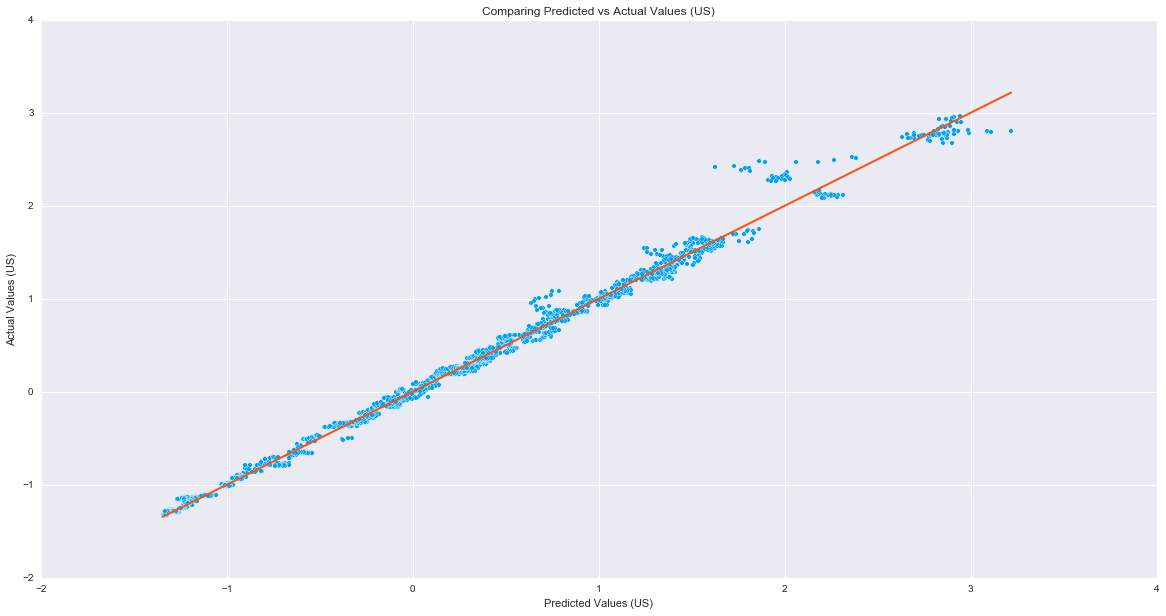

In [23]:
# plot predicted vs actual
fig = plt.figure(figsize=(20,10))
plt.scatter(y_test_plot , y_bar_plot, color='#00A1F1', edgecolors='white')
plt.plot( [np.min(y_test_plot), np.max(y_test_plot)], [np.min(y_test_plot),np.max(y_test_plot)], linewidth=2, color='#F65314')
plt.xlabel('Predicted Values (US)')
plt.ylabel('Actual Values (US)')
plt.title('Comparing Predicted vs Actual Values (US)')

---

# *UK Eurodollar Rate:*
## Using US model to predict 6-month UK Rates, using 30 day windows of 1-month and 3-month UK Rates as input

---

## Data Wrangling

In [24]:
# read in 1-Month, 3-Month, 6-Month UK Eurodollar rates
uk_one_month = pd.read_csv('DED1.csv')
uk_three_month = pd.read_csv('DED3.csv')
uk_six_month = pd.read_csv('DED6.csv')

In [25]:
# cut data to have same date range as US data
uk_one_month = uk_one_month[2870:]
uk_three_month = uk_three_month[2870:]
uk_six_month = uk_six_month[2870:]

In [26]:
# merge into single DataFrame
uk_data = uk_one_month.merge(uk_three_month, on = 'DATE')
uk_data = uk_data.merge(uk_six_month, on = 'DATE')

In [27]:
# rename columns
uk_data.columns = ['date', '1_rate', '3_rate', '6_rate']

In [28]:
# remove blank rows
uk_data = uk_data[uk_data['1_rate'] != '.']
uk_data = uk_data[uk_data['3_rate'] != '.']
uk_data = uk_data[uk_data['6_rate'] != '.']

In [29]:
# convert to float
uk_data['1_rate'] = uk_data['1_rate'].astype(float)
uk_data['3_rate'] = uk_data['3_rate'].astype(float)
uk_data['6_rate'] = uk_data['6_rate'].astype(float)

In [30]:
# normalize data to heave mean = 0, std = 1
uk_data['1_norm'] = (uk_data['1_rate'] - uk_data['1_rate'].mean(axis=0)) / uk_data['1_rate'].std(axis=0, ddof=1)
uk_data['3_norm'] = (uk_data['3_rate'] - uk_data['3_rate'].mean(axis=0)) / uk_data['3_rate'].std(axis=0, ddof=1)
uk_data['6_norm'] = (uk_data['6_rate'] - uk_data['6_rate'].mean(axis=0)) / uk_data['6_rate'].std(axis=0, ddof=1)

In [31]:
# cut by a number divisible by 30
uk_data = uk_data[:8730]

## Window

In [32]:
index_count = 0

# create first entries of the sampling window
uk_window_x = (uk_data[['1_norm', '3_norm']].values[0:30]).reshape((1,60))
uk_window_y = (uk_data[['6_norm']].values[0:30]).reshape((1,30))

# iterate through the dataframe and append each successive sampling window
for i in xrange(30,8730,30):
    uk_temp_x = (uk_data[['1_norm', '3_norm']].values[i:i+30]).reshape((1,60))
    uk_window_x = np.concatenate((uk_window_x, uk_temp_x))
    
    uk_temp_y = (uk_data[['6_norm']].values[i:i+30]).reshape((1,30))
    uk_window_y = np.concatenate((uk_window_y, uk_temp_y)) 

    index_count += 1

In [33]:
# print shape of x window
uk_window_x.shape

(291, 60)

In [34]:
# print shape of x window
uk_window_y.shape

(291, 30)

In [35]:
# print mean squared error of test set
uk_y_bar = fa.get_y_pred(uk_window_x)
print (((uk_window_y - uk_y_bar) ** 2).mean(axis=0))

[ 0.00580191  0.0060507   0.00545878  0.00569133  0.00654521  0.00533517
  0.00563537  0.00498606  0.00591548  0.00546798  0.00622871  0.00656063
  0.00646582  0.00594878  0.00504452  0.00570939  0.00594711  0.00521669
  0.00524867  0.00424148  0.00339435  0.00373881  0.00324236  0.00291349
  0.00310403  0.00362422  0.00409976  0.00498097  0.00559562  0.0054311 ]


In [36]:
# reshape for plotting purposes
uk_y_test_plot = uk_window_y.reshape(8730,1)
uk_y_bar_plot = uk_y_bar.reshape(8730,1)

## Plot

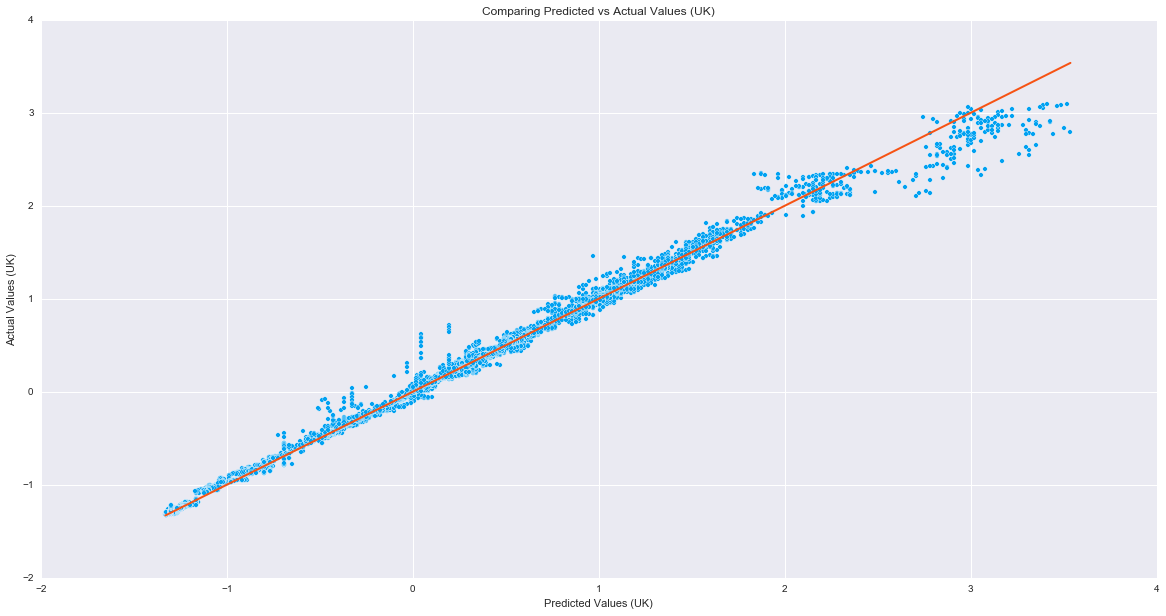

In [37]:
# plot predicted vs actual
fig = plt.figure(figsize=(20,10))
plt.scatter(uk_y_test_plot , uk_y_bar_plot, color='#00A1F1', edgecolors='white')
plt.plot( [np.min(uk_y_test_plot), np.max(uk_y_test_plot)], [np.min(uk_y_test_plot),np.max(uk_y_test_plot)], linewidth=2, color='#F65314')
plt.xlabel('Predicted Values (UK)')
plt.ylabel('Actual Values (UK)')
plt.title('Comparing Predicted vs Actual Values (UK)')

### It appears that in general, the Neural Network does a pretty good job of fitting UK data. However, at high rates the Neural Network seems to overpredict a little bit. I don't know enough about UK rates vs US rates to explain why, but I suppose its possible that UK rates simply never reach as high levels as US rates historically.